# This is an MCMC on $\Omega_c$ and NK Bias

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib


%matplotlib inline

print("CCL version you are using:",ccl.__version__)
print(ccl.__file__)
ccl_dir = '/global/homes/z/zhzhuoqi/CCL/'

CCL version you are using: 2.1.0
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/pyccl/__init__.py


In [2]:
import sys
sys.path.insert(0, '/global/homes/z/zhzhuoqi/.local/lib/python2.7/site-packages/TreeCorr-4.1-py2.7-linux-x86_64.egg')

In [3]:
import treecorr
treecorr.__version__

'4.1'

In [4]:
import GCRCatalogs
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import healpy as hp
import camb
import camb.correlations
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show, colorbar

## This is the part for Treecorr measurement

In [5]:
#functions in this cell are those for treecorr measurement

def get_healpixel_footprint(ra, dec, nside, nest=False, count_threshold=None):
    pixels = hp.ang2pix(nside, ra, dec, nest=nest, lonlat=True)
    if count_threshold and count_threshold > 1:
        pixels, counts = np.unique(pixels, return_counts=True)
        return pixels[counts >= count_threshold]
    return np.unique(pixels)
def generate_uniform_random_ra_dec_healpixel(n, pix, nside, nest=False):

    ra, dec = hp.vec2ang(hp.boundaries(nside, pix, 1, nest=nest).T, lonlat=True)
    ra_dec_min_max = ra.min(), ra.max(), dec.min(), dec.max()

    ra = np.empty(n)
    dec = np.empty_like(ra)
    n_needed = n

    while n_needed > 0:
        ra_this, dec_this = generate_uniform_random_ra_dec_min_max(n_needed*2, *ra_dec_min_max)
        mask = np.where(hp.ang2pix(nside, ra_this, dec_this, nest=nest, lonlat=True) == pix)[0]
        count_this = mask.size
        if n_needed - count_this < 0:
            count_this = n_needed
            mask = mask[:n_needed]

        s = slice(-n_needed, -n_needed+count_this if -n_needed+count_this < 0 else None)
        ra[s] = ra_this[mask]
        dec[s] = dec_this[mask]
        n_needed -= count_this

    return ra, dec

def generate_uniform_random_ra_dec_min_max(n, ra_min, ra_max, dec_min, dec_max):

    ra = np.random.uniform(ra_min, ra_max, size=n)
    dec = np.random.uniform(np.sin(np.deg2rad(dec_min)), np.sin(np.deg2rad(dec_max)), size=n)
    dec = np.arcsin(dec, out=dec)
    dec = np.rad2deg(dec, out=dec)
    return ra, dec

def generate_uniform_random_ra_dec_footprint(n, footprint=None, nside=None, nest=False):

    if footprint is None or hp.nside2npix(nside) == len(footprint):
        return generate_uniform_random_ra_dec(n)

    n_per_pix_all = np.histogram(np.random.rand(n), np.linspace(0, 1, len(footprint)+1))[0]

    ra = np.empty(n)
    dec = np.empty_like(ra)
    count = 0

    for n_per_pix, pix in zip(n_per_pix_all, footprint):
        ra_this, dec_this = generate_uniform_random_ra_dec_healpixel(n_per_pix, pix, nside, nest)
        s = slice(count, count+n_per_pix)
        ra[s] = ra_this
        dec[s] = dec_this
        count += n_per_pix

    assert count == n

    return ra, dec

In [6]:
filename = '/global/projecta/projectdirs/lsst/groups/CS/cosmoDC2/mass_sheets_behind_z3/cmb_maps/cmblensmap_total_gausshiz_masked.fits'

In [7]:
mapfile = hp.read_map(filename)
print(len(mapfile))

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
201326592


In [8]:
index = np.arange(201326592)
theta, phi = hp.pix2ang(nside=4096, ipix=index)

In [9]:
gc = GCRCatalogs.load_catalog('cosmoDC2')

In [10]:
data = gc.get_quantities(['ra', 'dec', 'shear_1', 'shear_2', 'redshift', 'mag_i_lsst'], filters=['mag_i_lsst<22'])

In [11]:
def get_measurement(zmax, zmin):
    redshift_mask = (data['redshift']<zmax)*(data['redshift']>zmin)

    #cut out the CosmoDC2 region from KCMB
    nside = 512
    healpix_id = get_healpixel_footprint(data['ra'][redshift_mask], data['dec'][redshift_mask], nside) 
    npix = hp.nside2npix(nside)
    m = np.zeros(npix)
    m[healpix_id]=1
    new = hp.ud_grade(m, 4096)
    cmb_mask = new>0
    ra_K = np.degrees(phi[cmb_mask])
    dec_K = np.degrees(np.pi/2-theta[cmb_mask])
    kcmb = mapfile[cmb_mask]

    #number count catalog
    cat_N = treecorr.Catalog(ra=data['ra'][redshift_mask], dec=data['dec'][redshift_mask], ra_units='deg', dec_units='deg', npatch=40)
    Npatch = cat_N.patch
    Npatch_center = cat_N.get_patch_centers()

    #KCMB catalog
    cat_K = treecorr.Catalog(ra=ra_K, dec=dec_K, k=kcmb, ra_units='deg', dec_units='deg', patch_centers=Npatch_center)
    Kpatch=cat_K.patch

    #generate random ra and dec
    n = 10*len(data['ra'][redshift_mask])
    nside = 512
    ra_random, dec_random = generate_uniform_random_ra_dec_footprint(n, footprint=healpix_id, nside=nside, nest=False)

    #random catalog
    cat_N_random = treecorr.Catalog(ra=ra_random, dec=dec_random, ra_units='deg', dec_units='deg', patch_centers=Npatch_center)
    Rpatch=cat_N_random.patch

    #random correlation with jackknife
    nk_rand = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')
    nk_rand.process(cat_N_random, cat_K)

    #get NK predictions and errors
    nk_jk = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')
    nk_jk.process(cat_N, cat_K)
    nk_jk.calculateXi(rk=nk_rand)
    xi_nk = nk_jk.xi
    R_nk = np.exp(nk_jk.logr)
    cov_nk = nk_jk.cov

    #shear catalog
    cat_G = treecorr.Catalog(ra=data['ra'][redshift_mask], dec=data['dec'][redshift_mask],g1=data['shear_1'][redshift_mask], g2=data['shear_2'][redshift_mask], ra_units='deg', dec_units='deg', patch_centers=Npatch_center)

    #get GK predictions and errors
    kg = treecorr.KGCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')
    kg.process(cat_K, cat_G)
    xi_kg = kg.xi
    cov_kg = kg.cov
    R_kg = np.exp(kg.logr)

    results = {}
    results['R'] = np.degrees(R_kg)
    results['nk'] = {}
    results['nk']['xi'] = xi_nk
    results['nk']['cov'] = cov_nk
    results['gk'] = {}
    results['gk']['xi'] = xi_kg
    results['gk']['var'] = cov_kg

    
    return results

In [12]:
#get measurement
zmax = 0.62
zmin = 0.43
measurement = get_measurement(zmax, zmin)
theta_deg = measurement['R']
xi = measurement['nk']['xi']
cov = measurement['nk']['cov']

## This is the ccl part

In [13]:
# some set-up for get_prediction function (pull out from the function to reduce MCMC running time)
redshift_mask = (data['redshift']<zmax)*(data['redshift']>zmin)
zhist = np.histogram(data['redshift'][redshift_mask], bins=100)
#plt.xlabel('z')
z = (zhist[1][1:]+zhist[1][:-1])/2
z_h = zhist[0]/np.sum(zhist[0])

ells=np.linspace(2,3000,2999).astype(int)

#Limber prefactors 
lf_dl=(ells+0.5)**2/np.sqrt((ells+2.)*(ells+1.)*ells*(ells-1.))
lf_dc=(ells+0.5)**2/(ells*(ells+1.))
lf_ll=ells*(ells+1.)/np.sqrt((ells+2.)*(ells+1.)*ells*(ells-1.))

In [14]:
def get_prediction(parameter, theta_deg): #parameter is an np array. parameter[0] is omega_c, parameter[1] is h

    #generate bias
    bz=parameter[1]*np.ones_like(z_h)

    # Initialize tracers  
    cosmo_cls=ccl.Cosmology(Omega_c=parameter[0], Omega_b=0.0045, Omega_g=0, Omega_k=0,
                              h=0.71, sigma8=0.8, n_s=0.963, Neff=0, m_nu=0.0,
                              w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                              mass_function='tinker')
    cosmo_cls.cosmo.gsl_params.INTEGRATION_LIMBER_EPSREL = 1E-4
    cosmo_cls.cosmo.gsl_params.INTEGRATION_EPSREL = 1E-4   

    #generate tracers 
    trcrs={}
    trcrs['nc']=ccl.NumberCountsTracer(cosmo_cls,has_rsd=False,dndz=(z,z_h),bias=(z,bz))
    #trcrs['wl']=ccl.WeakLensingTracer(cosmo_cls,dndz=(z,z_h))
    trcrs['cmbl']=ccl.CMBLensingTracer(cosmo_cls,1100.)

    #CCL Power spectra
    cl_ccl={}
    cl_ccl['nc/cmbl']=ccl.angular_cl(cosmo_cls,trcrs['nc'],trcrs['cmbl'],ells)*lf_dc
    #cl_ccl['wl/cmbl']=ccl.angular_cl(cosmo_cls,trcrs['wl'],trcrs['cmbl'],ells)*lf_ll

    win = hp.pixwin(4096)[:2999]
    cl_ccl['nc/cmbl'] = cl_ccl['nc/cmbl']*win
    #cl_ccl['wl/cmbl'] = cl_ccl['wl/cmbl']*win

    #theta array 
    #theta_deg = np.degrees(R_kg)

    #generate correlations from power spectrum 
    corr={}

    ell = ells
    cell = cl_ccl['nc/cmbl']
    corr['nk'] = ccl.correlation(cosmo_cls, ell, cell, theta_deg, corr_type='GG', method='Bessel')

    #cell = cl_ccl['wl/cmbl']
    #corr['gk']=ccl.correlation(cosmo_cls, ell, cell, theta_deg, corr_type='GL', method='Bessel')
    
    
    return corr

## This is the MCMC part

<font size="3">Our log-likelihood function is $$L=-\frac{1}{2}(D-M)^TC^{-1}(D-M)-\frac{1}{2}\ln\det{C}-\frac{N}{2}\ln2\pi$$ where $M$ is the measurement, $D$ is the prediction, $C$ is the Jackknife covariance matrix obtained in the treecorr measurement. Note that the last term is a constant.

In [15]:
def log_likelihood(parameter, theta_deg, xi, cov):
    model = get_prediction(parameter, theta_deg)
    D = model['nk']
    C = cov
    M = xi
    L = - 0.5*np.dot(np.dot((D-M),scipy.linalg.inv(C)), D-M) - 0.5*np.log(scipy.linalg.det(cov))
    return L


<font size="3">Here is the prior distribution

In [16]:
def log_prior(parameter):
    omega_c = parameter[0]
    b = parameter[1]
    if 0.1 < omega_c < 0.4 and 0.0 < b < 3.0:
        return np.log(1.0/0.06)
    return -np.inf

In [17]:
def log_probability(parameter, theta_deg,xi,cov): 
    lp = log_prior(parameter)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood(parameter,theta_deg,xi,cov)

In [19]:
import emcee

pos = np.array([0.23, 1.00]) + 1e-2 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(theta_deg, xi, cov))
sampler.run_mcmc(pos, 500, progress=True);

100%|██████████| 500/500 [2:42:12<00:00, 19.47s/it]  


In [20]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(832, 2)


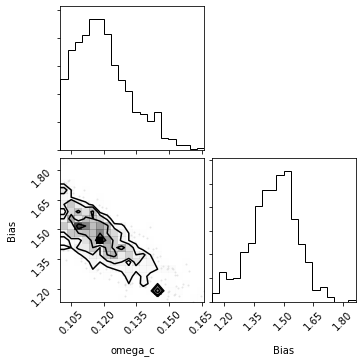

In [23]:
import corner
samples = sampler.get_chain()
fig = corner.corner(
    flat_samples, labels=["omega_c", "Bias"]
);

In [24]:
print(np.mean(flat_samples,axis=0))

[0.12016493 1.44877004]
